In [ ]:
import torch
print(torch.__version__)

2.4.1+cu121


In [ ]:
!python --version

Python 3.10.12


# <font color = 'indianred'>**Multilabel Classification of StackExchange Dataset using DistilBert** </font>

**Objective:**

In this notebook, we aim to build the base model without accounting for the data imbalance. We will learn how the label imbalance can influence our results.


**Plan**

1. Set Environment
2. Load Dataset
3. Accessing and Manipulating Splits
4. Load Pre-trained Tokenizer
5. Create Function for Tokenizer
4. Train Model
  1. Download pre-trained model <br>
  2. Download and modify the model config file <br>
  3. Compute Metric Function <br>
  4. Training Arguments <br>
  5. Instantiate Trainer <br>
  6. Setup WandB <br>
  7. Training and Validation
6. Perfromance on Test Set
7. Model Inference






















# <font color = 'indianred'> **1. Setting up the Environment** </font>



In [ ]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  # !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate -U -qq ## NEW LINES ##
  basepath = '/content/drive/MyDrive/data/'
else:
  basepath = '/home/harpreet/Insync/google_drive_shaannorr/data'

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.9 MB/s eta 0:00:00


<font color = 'indianred'> *Load Libraries* </font>

In [ ]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import joblib


# New libraries introduced in this notebook
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig
from transformers import pipeline
import wandb
from google.colab import userdata
from huggingface_hub import login
import torch.nn as nn
import ast

In [ ]:
wandb_api_key = userdata.get('WANDB_API_KEY')
hf_token = userdata.get('HF_TOKEN')


In [ ]:
if hf_token:
    # Log in to Hugging Face
    login(token=hf_token)
    print("Successfully logged in to Hugging Face!")
else:
    print("Hugging Face token not found in notebook secrets.")


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful
Successfully logged in to Hugging Face!


In [ ]:
if wandb_api_key:
  wandb.login(key=wandb_api_key)
  print("Successfully logged in to WANDB!")
else:
    print("WANDB key not found in notebook secrets.")


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Successfully logged in to WANDB!


In [ ]:
# CHANGE FOLDERS TO WHERE YOU WANT TO SAVE DATA AND MODELS
base_folder = Path(basepath)
data_folder = base_folder/'datasets/Classification_HW/joblib_files'

# <font color = 'indianred'> **2. Load Data set**
    


In [ ]:
df = joblib.load(data_folder/'df_multilabel_hw_cleaned.joblib')
df

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]"
...,...,...,...
47422,take value edittext put decimal point all- wor...,java android,"[1, 4]"
47423,listen phone state application nee liste phone...,java android,"[1, 4]"
47424,android ui thread thread task want access main...,java android,"[1, 4]"
47425,dynamic table row creation html javascript htm...,asp.net javascript,"[9, 3]"


In [ ]:
stack_dataset = Dataset.from_pandas(df)

In [ ]:
selected_columns = {
    'text': stack_dataset['cleaned_text'],
    'tag': stack_dataset['Tag_Number']
}

# Create a new dataset with the selected columns
stack_selected_columns = Dataset.from_dict(selected_columns)

In [ ]:
# Set the format to Pandas
stack_selected_columns.set_format(type='pandas')

In [ ]:
df = stack_selected_columns[:]

In [ ]:
df['tag_mod'] = df['tag'].apply(lambda x: ast.literal_eval(x))

In [ ]:
# check distribution of class labels in the dataset
print(df['tag_mod'].explode().value_counts())

tag_mod
3    27357
5    25038
9    12466
0    10451
1     8307
4     7607
2     5732
6      759
7      587
8      315
Name: count, dtype: int64


In [ ]:
print(df['tag_mod'].value_counts())

tag_mod
[3, 5]          19989
[0, 9]           7986
[1, 4]           6922
[2, 3]           2165
[2, 5]           1499
                ...  
[0, 5, 3]           1
[2, 5, 9]           1
[1, 6, 8]           1
[1, 3, 9, 6]        1
[3, 8, 9]           1
Name: count, Length: 176, dtype: int64


In [ ]:
label_encoder = MultiLabelBinarizer()

In [ ]:
df['label'] = list(label_encoder.fit_transform(df['tag_mod']))

In [ ]:
df

,text,tag,tag_mod,label
0,asp query stre dropdown webpage follow control...,"[0, 9]","[0, 9]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,run javascript code server java code want run ...,"[1, 3]","[1, 3]","[0, 1, 0, 1, 0, 0, 0, 0, 0, 0]"
2,linq sql throw exception row find change hi li...,"[0, 9]","[0, 9]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
3,run python script php server run nginx web ser...,"[2, 7]","[2, 7]","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0]"
4,advice write function m try write function res...,"[3, 5]","[3, 5]","[0, 0, 0, 1, 0, 1, 0, 0, 0, 0]"
...,...,...,...,...
47422,take value edittext put decimal point all- wor...,"[1, 4]","[1, 4]","[0, 1, 0, 0, 1, 0, 0, 0, 0, 0]"
47423,listen phone state application nee liste phone...,"[1, 4]","[1, 4]","[0, 1, 0, 0, 1, 0, 0, 0, 0, 0]"
47424,android ui thread thread task want access main...,"[1, 4]","[1, 4]","[0, 1, 0, 0, 1, 0, 0, 0, 0, 0]"
47425,dynamic table row creation html javascript htm...,"[9, 3]","[9, 3]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1]"


In [ ]:
df_final = df[['text', 'label']]

In [ ]:
df_final

,text,label
0,asp query stre dropdown webpage follow control...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,run javascript code server java code want run ...,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0]"
2,linq sql throw exception row find change hi li...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
3,run python script php server run nginx web ser...,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 0]"
4,advice write function m try write function res...,"[0, 0, 0, 1, 0, 1, 0, 0, 0, 0]"
...,...,...
47422,take value edittext put decimal point all- wor...,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0]"
47423,listen phone state application nee liste phone...,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0]"
47424,android ui thread thread task want access main...,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0]"
47425,dynamic table row creation html javascript htm...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 1]"


In [ ]:
class_names = ['c#', 'java', 'php','javascript', 'android', 'jquery', 'c++',  'python', 'iphone', 'asp.net']

In [ ]:
stack_selected_columns_final = Dataset.from_pandas(df_final)

# <font color = 'indianred'> **3. Accessing and Manuplating Splits**</font>



<font color = 'indianred'>*Create futher subdivions of the splits*</font>

In [ ]:
# Split the test set into test and validation sets
test_val_splits = stack_selected_columns_final.train_test_split(test_size=0.4, seed=42)
train_split= test_val_splits['train']
test_val_splits = test_val_splits['test'].train_test_split(test_size=0.5, seed=42,)
val_split = test_val_splits['train']
test_split = test_val_splits['test']


<font color = 'indianred'>*small subset for initial experimenttaion*</font>

In [ ]:
train_split = train_split.shuffle(seed = 42).select(range(2000))
val_split = val_split.shuffle(seed = 42).select(range(2000))
test_split = test_split.shuffle(seed = 42).select(range(2000))

In [ ]:
train_val_subset= DatasetDict(
    {"train": train_split, "valid": val_split})

In [ ]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train_val_subset['train']['label'][0]

[0, 0, 0, 1, 0, 1, 0, 0, 0, 0]

# <font color = 'indianred'>**4. Load pre-trained Tokenizer**</font>



In [ ]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

#<font color = 'indianred'> **5. Create function for Tokenizer**



In [ ]:
# def tokenize_fn(batch):
#     return tokenizer(text = batch["text"], truncation=True, padding=True, return_tensors="pt")

def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True)

<font color = 'indianred'> *Use map function to apply tokenization to all splits*

In [ ]:
tokenized_dataset= train_val_subset.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    valid: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [ ]:
tokenized_dataset['train']['label'][0]

tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0])

In [ ]:
tokenized_dataset = (tokenized_dataset
          .map(lambda x : {"float_label": x["label"].to(torch.float)}, remove_columns=["label"])
          .rename_column("float_label", "label"))

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset['train']['label'][0:3]

tensor([[0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [ ]:
print(len(tokenized_dataset["train"]["input_ids"][2]))
print(len(tokenized_dataset["train"]["input_ids"][1]))

133
387


#  <font color = 'indianred'> **6. Model Training**

##  <font color = 'indianred'> **6.1 Download pre-trained model**

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 10, problem_type="multi_label_classification")  # We are using the same checkpiont as we have used for tokenizer


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##  <font color = 'indianred'> **6.2 Downaload and Modify Model Config File**

In [ ]:
config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}
config.id2label = id2label
config.label2id = label2id
model.config = config


##  <font color = 'indianred'> **6.3 compute_metrics function** </font>



In [ ]:
y_true = np.array([[0, 0, 0], [1, 1, 1], [0, 1, 1]])
logits = np.array([[-0.2, -0.2, -0.2], [0.8, 0.8, 0.8], [0.7, 0.7, -3]])
eval_pred_s = ( logits, y_true,)
y_pred = [[0, 0, 0], [1, 1, 1], [1, 1, 0]]
import numpy as np
from sklearn.metrics import f1_score
print(f1_score(y_true, y_pred, average='macro'))
print(f1_score(y_true, y_pred, average='micro'))

0.7777777777777777
0.8


In [ ]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
def compute_metrics_sklearn(eval_pred):
    logits, labels = eval_pred
    labels = labels.astype(int)  # Ensure labels are integers

    # Convert logits to binary predictions
    predictions = (logits > 0).astype(int)

    # Compute F1 scores for macro and micro averaging
    macro_f1 = f1_score(labels, predictions, average='macro')
    micro_f1 = f1_score(labels, predictions, average='micro')

    # Compute label-wise accuracies
    correct_predictions = (predictions == labels).sum(axis=0)
    total_examples = labels.shape[0]
    label_accuracies = correct_predictions / total_examples

    # Compute the average label accuracy
    avg_label_accuracy = np.mean(label_accuracies)

    # Compute accuracy where all labels for an observation need to be correct
    all_accuracy = accuracy_score(labels, predictions, normalize=True)

    evaluations = {
        'macro_f1': macro_f1,
        'micro_f1': micro_f1,
        'accuracy_all': all_accuracy,
        'avg_label_accuracy': avg_label_accuracy
    }

    return evaluations

In [ ]:
compute_metrics_sklearn(eval_pred_s)

{'macro_f1': 0.7777777777777777,
 'micro_f1': 0.8,
 'accuracy_all': 0.6666666666666666,
 'avg_label_accuracy': 0.7777777777777777}

In [ ]:
# load training metrices
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    preds = (logits > 0).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}


In [ ]:
compute_metrics(eval_pred_s)

{'f1_micro': 0.8,
 'f1_macro': 0.7777777777777777,
 'accuracy_label': 0.7777777777777778,
 'accuracy_all': 0.6666666666666666}

## <font color = 'indianred'> **6.4 Training Arguments**</font>







In [ ]:
# Define the directory where model checkpoints will be saved
model_folder = base_folder / "models"/"nlp_fall_2024/stack/bert"
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)
run_name= 'stack_exp_imb_exp1'

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=16,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= run_name,  # Experiment name for Weights & Biases
)


##  <font color = 'indianred'> **6.5 Initialize Trainer**</font>



In [ ]:
# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)


## <font color = 'indianred'> **6.6 Setup WandB**</font>

In [ ]:
%env WANDB_PROJECT = multilabel_stack

env: WANDB_PROJECT=multilabel_stack


##  <font color = 'indianred'> **6.7 Training and Validation**

In [ ]:
trainer.train()  # start training

Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy Label,Accuracy All
20,0.317400,0.298121,0.770812,0.447798,0.911900,0.608000
40,0.297100,0.271040,0.778324,0.459094,0.914300,0.612000
60,0.249400,0.250245,0.790374,0.466973,0.918550,0.630000
80,0.243500,0.238554,0.795831,0.496701,0.918700,0.640000
100,0.230900,0.225690,0.812857,0.529755,0.926350,0.640000
120,0.224500,0.217289,0.820584,0.543756,0.928700,0.649000
140,0.228900,0.209174,0.837700,0.567417,0.934650,0.671000
160,0.193200,0.203973,0.833148,0.556879,0.932550,0.674500
180,0.173800,0.199731,0.838654,0.567570,0.934550,0.684500
200,0.187200,0.195982,0.843079,0.574624,0.936400,0.685500


TrainOutput(global_step=250, training_loss=0.2250964331626892, metrics={'train_runtime': 176.275, 'train_samples_per_second': 22.692, 'train_steps_per_second': 1.418, 'total_flos': 480126202305600.0, 'train_loss': 0.2250964331626892, 'epoch': 2.0})

<font color = 'indianred'> *Evaluate model on Validation Set* </font>


In [ ]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [ ]:
eval_results

{'eval_loss': 0.19598156213760376,
 'eval_f1_micro': 0.8430792005921539,
 'eval_f1_macro': 0.5746241317413924,
 'eval_accuracy_label': 0.9364,
 'eval_accuracy_all': 0.6855,
 'eval_runtime': 8.0241,
 'eval_samples_per_second': 249.251,
 'eval_steps_per_second': 15.578,
 'epoch': 2.0}

In [ ]:
wandb.log({"eval_f1_macro": eval_results["eval_f1_macro"], "eval_loss": eval_results["eval_loss"], "eval_accuracy": eval_results["eval_accuracy_all"]})

<font color = 'indianred'> *Confusion Matrix*</font>

In [ ]:
valid_output = trainer.predict(tokenized_dataset["valid"])

In [ ]:
valid_preds = np.array((valid_output.predictions > 0).astype(int))
valid_labels = np.array(valid_output.label_ids.astype(int))


In [ ]:
mcm = multilabel_confusion_matrix(valid_labels, valid_preds)
print(mcm)

[[[1443  113]
  [ 106  338]]

 [[1640   29]
  [  68  263]]

 [[1755   24]
  [  76  145]]

 [[ 677  137]
  [ 121 1065]]

 [[1668   26]
  [  59  247]]

 [[ 859   70]
  [  96  975]]

 [[1966    0]
  [  34    0]]

 [[1976    0]
  [  24    0]]

 [[1986    0]
  [  14    0]]

 [[1341  124]
  [ 151  384]]]


In [ ]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats


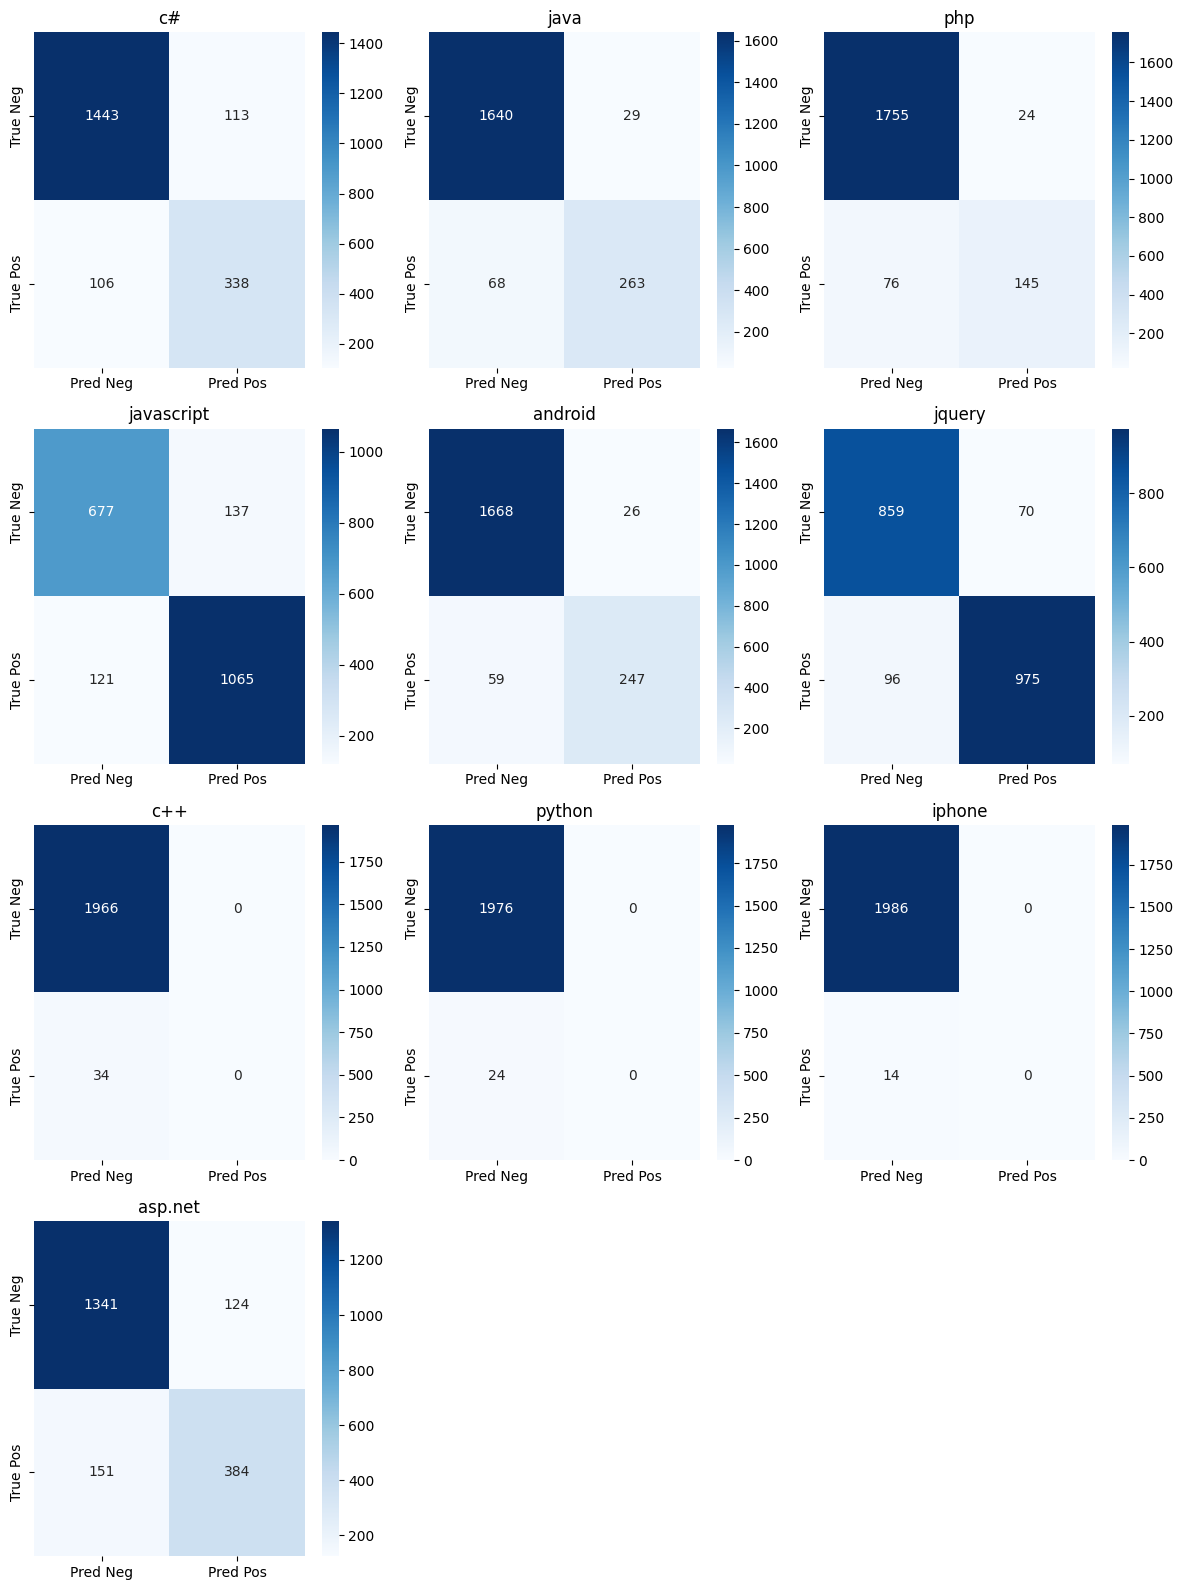

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


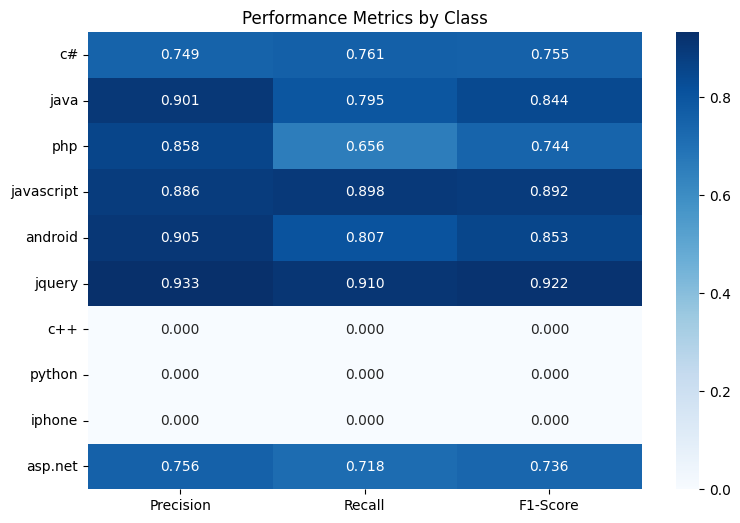

<Figure size 1200x533.333 with 0 Axes>

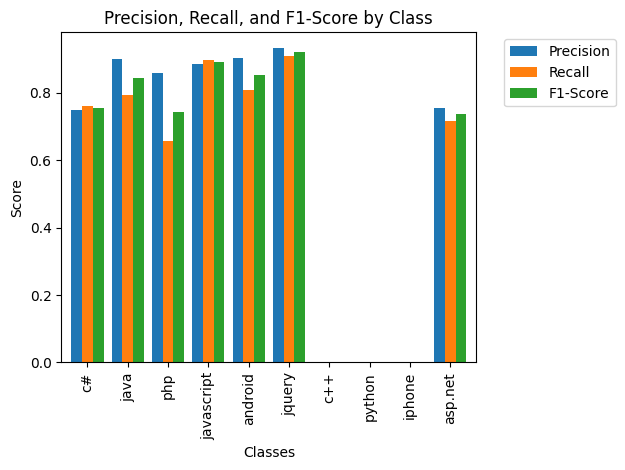

{'macro_avg': {'precision': 0.5987823838611332,
  'recall': 0.5545218880799819,
  'f1': 0.5746241317413924},
 'per_class': {'Precision': {'c#': 0.7494456762749445,
   'java': 0.9006849315068494,
   'php': 0.8579881656804734,
   'javascript': 0.8860232945091514,
   'android': 0.9047619047619048,
   'jquery': 0.9330143540669856,
   'c++': 0.0,
   'python': 0.0,
   'iphone': 0.0,
   'asp.net': 0.7559055118110236},
  'Recall': {'c#': 0.7612612612612613,
   'java': 0.7945619335347432,
   'php': 0.6561085972850679,
   'javascript': 0.8979763912310287,
   'android': 0.8071895424836601,
   'jquery': 0.9103641456582633,
   'c++': 0.0,
   'python': 0.0,
   'iphone': 0.0,
   'asp.net': 0.7177570093457943},
  'F1-Score': {'c#': 0.7553072625698324,
   'java': 0.8443017656500803,
   'php': 0.7435897435897436,
   'javascript': 0.8919597989949749,
   'android': 0.853195164075993,
   'jquery': 0.9215500945179584,
   'c++': 0.0,
   'python': 0.0,
   'iphone': 0.0,
   'asp.net': 0.7363374880153404}}}

In [ ]:
multilabel_evaluation(y_true=valid_labels, y_pred=valid_preds, class_names=class_names, figsize=(12, 8))

<font color = 'indianred'> *Get best checkpoint*</font>


In [ ]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")


The best model was saved at step 200.


#  <font color = 'indianred'> **7. Performance on Test Set** </font>
For test set evaluation, we will perfrom following steps:



In [ ]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/drive/MyDrive/data/models/nlp_fall_2024/stackexc/bert/checkpoint-200'

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
test_set_tokenized = test_split.map(tokenize_fn, batched=True)


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
test_set_tokenized

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2000
})

In [ ]:
test_set_tokenized.set_format(type='torch')
test_set_tokenized = (test_set_tokenized
          .map(lambda x : {"float_label": x["label"].to(torch.float)}, remove_columns=["label"])
          .rename_column("float_label", "label"))

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

<font color = 'indianred'>*Training Arguments*</font>

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=128,
    do_train=False,
    do_eval=True,
    report_to=[],
    run_name=run_name
)

<font color = 'indianred'>*Instantiate Trainer*</font>

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_set_tokenized,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

<font color = 'indianred'>*Evaluate using Trainer*</font>

In [ ]:
test_results= trainer.evaluate()

In [ ]:
test_results

{'eval_loss': 0.1983492374420166,
 'eval_model_preparation_time': 0.0018,
 'eval_f1_micro': 0.8404150197628458,
 'eval_f1_macro': 0.5704524472810544,
 'eval_accuracy_label': 0.9354,
 'eval_accuracy_all': 0.691,
 'eval_runtime': 7.6313,
 'eval_samples_per_second': 262.079,
 'eval_steps_per_second': 2.097}

In [ ]:
wandb.log({"test_f1_macro": test_results["eval_f1_macro"], "test_loss": test_results["eval_loss"], "test_accuracy": test_results["eval_accuracy_all"]})

<font color = 'indianred'>*Confusion Matrix*</font>

In [ ]:
test_preds = np.array((test_output.predictions > 0).astype(int))
test_labels = np.array(test_output.label_ids.astype(int))


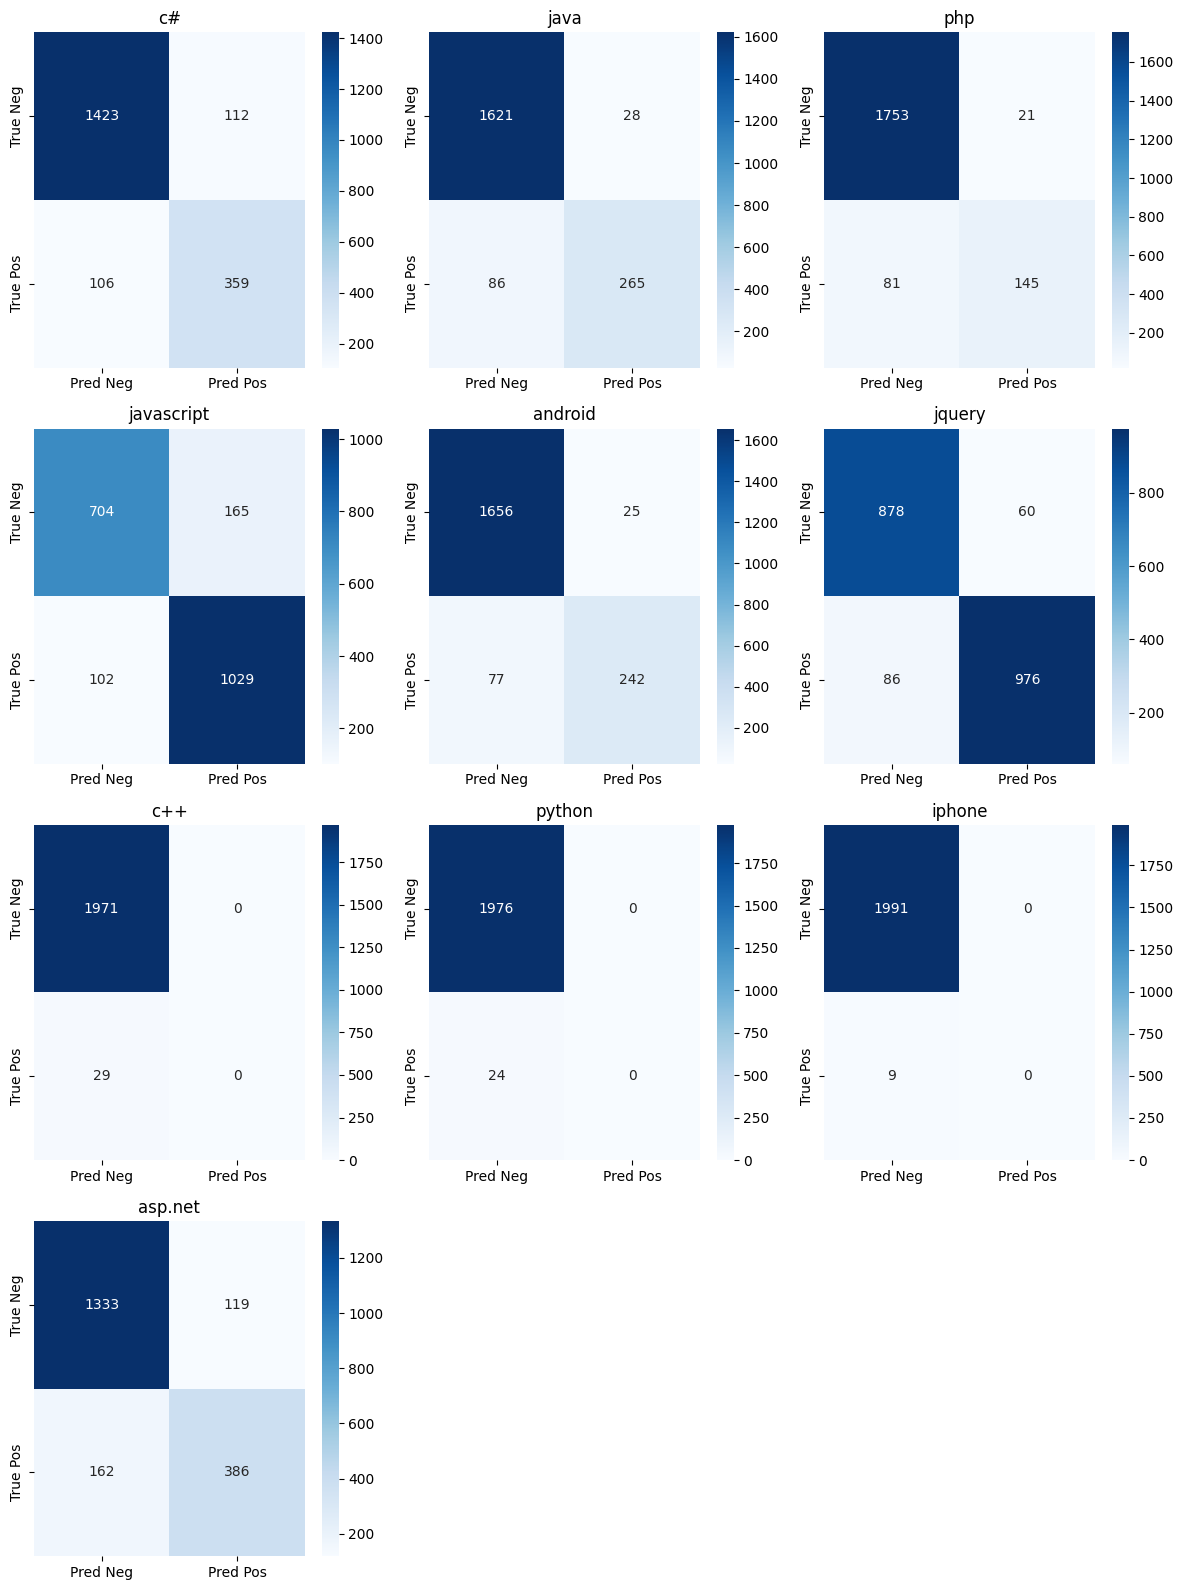

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


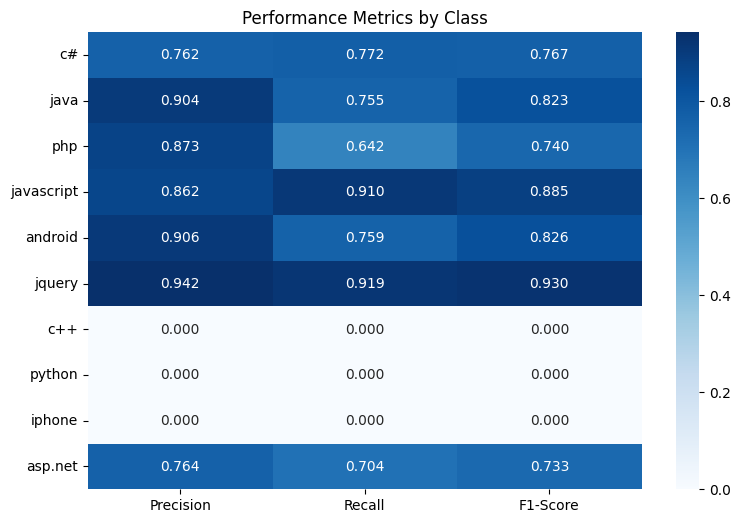

<Figure size 1200x533.333 with 0 Axes>

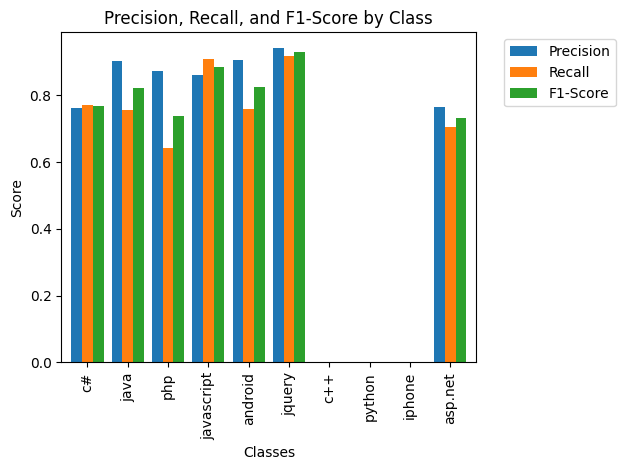

{'macro_avg': {'precision': 0.6014756368065565,
  'recall': 0.5460456977029706,
  'f1': 0.5704524472810544},
 'per_class': {'Precision': {'c#': 0.7622080679405521,
   'java': 0.9044368600682594,
   'php': 0.8734939759036144,
   'javascript': 0.8618090452261307,
   'android': 0.9063670411985019,
   'jquery': 0.9420849420849421,
   'c++': 0.0,
   'python': 0.0,
   'iphone': 0.0,
   'asp.net': 0.7643564356435644},
  'Recall': {'c#': 0.7720430107526882,
   'java': 0.7549857549857549,
   'php': 0.6415929203539823,
   'javascript': 0.9098143236074271,
   'android': 0.7586206896551724,
   'jquery': 0.9190207156308852,
   'c++': 0.0,
   'python': 0.0,
   'iphone': 0.0,
   'asp.net': 0.7043795620437956},
  'F1-Score': {'c#': 0.7670940170940171,
   'java': 0.8229813664596274,
   'php': 0.7397959183673469,
   'javascript': 0.8851612903225806,
   'android': 0.825938566552901,
   'jquery': 0.9304099142040038,
   'c++': 0.0,
   'python': 0.0,
   'iphone': 0.0,
   'asp.net': 0.7331433998100665}}}

In [ ]:
multilabel_evaluation(y_true=test_labels, y_pred=test_preds, class_names=class_names, figsize=(12, 8))

In [ ]:
wandb.finish()

eval/accuracy_all,▃▃▁▃▆▇▇▇▇▇███████
eval/accuracy_label,▁▁▃▄▇▇▇▇▇████████
eval/f1_macro,▁▁▁▂▆▆▆▇▇▇███████
eval/f1_micro,▁▁▁▃▆▆▇▇▇▇███████
eval/loss,█▆▆▅▃▃▂▂▂▂▁▁▁▁▁▁▁
eval/runtime,▂▁▆▇▁▂▂▇█▆▄▅▅▆▂▅▂
eval/samples_per_second,▇█▃▂█▇▇▂▁▃▅▄▄▃▇▄▆
eval/steps_per_second,▇█▃▂█▇▇▂▁▃▅▄▄▃▇▄▆
eval_accuracy,▁
eval_f1_macro,▁
eval_loss,▁


# <Font color = 'indianred'> **8. Model Inference**



In [ ]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
custom_pipeline = pipeline(
    task="text-classification",
    model=checkpoint,
    tokenizer=checkpoint,
    device=0,
    return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


<font color = 'indianred'> **Test the pipeline on a single example**

In [ ]:
sample = test_split['text'][0]
preds = custom_pipeline(sample)
preds


[[{'label': 'c#', 'score': 0.2206181287765503},
  {'label': 'java', 'score': 0.16066618263721466},
  {'label': 'php', 'score': 0.11544562876224518},
  {'label': 'javascript', 'score': 0.6392399668693542},
  {'label': 'android', 'score': 0.07882598787546158},
  {'label': 'jquery', 'score': 0.17962734401226044},
  {'label': 'c++', 'score': 0.03570567071437836},
  {'label': 'python', 'score': 0.029273593798279762},
  {'label': 'iphone', 'score': 0.03434183448553085},
  {'label': 'asp.net', 'score': 0.2966150939464569}]]

In [ ]:
def get_positive_labels(pipeline_output, threshold=0.5):

    positive_labels = []

    for pred_set in pipeline_output:
        # Get labels where score >= threshold
        sample_positives = [pred['label'] for pred in pred_set
                          if pred['score'] >= threshold]
        positive_labels.append(sample_positives)

    return positive_labels






In [ ]:
results = get_positive_labels(preds, threshold=0.5)
results

[['javascript']]

<font color = 'indianred'> **Test the pipeline on a large dataset**

In [ ]:
preds = custom_pipeline(test_split['text'], truncation=True)

In [ ]:
preds[0:3]


[[{'label': 'c#', 'score': 0.2206181287765503},
  {'label': 'java', 'score': 0.16066618263721466},
  {'label': 'php', 'score': 0.11544562876224518},
  {'label': 'javascript', 'score': 0.6392399668693542},
  {'label': 'android', 'score': 0.07882598787546158},
  {'label': 'jquery', 'score': 0.17962734401226044},
  {'label': 'c++', 'score': 0.03570567071437836},
  {'label': 'python', 'score': 0.029273593798279762},
  {'label': 'iphone', 'score': 0.03434183448553085},
  {'label': 'asp.net', 'score': 0.2966150939464569}],
 [{'label': 'c#', 'score': 0.10005486011505127},
  {'label': 'java', 'score': 0.03944573923945427},
  {'label': 'php', 'score': 0.04369588568806648},
  {'label': 'javascript', 'score': 0.7922108173370361},
  {'label': 'android', 'score': 0.035620953887701035},
  {'label': 'jquery', 'score': 0.8664469122886658},
  {'label': 'c++', 'score': 0.023083563894033432},
  {'label': 'python', 'score': 0.021454643458127975},
  {'label': 'iphone', 'score': 0.024503491818904877},
  {'l

In [ ]:
results = get_positive_labels(preds, threshold=0.5)
results[0:3]

[['javascript'], ['javascript', 'jquery'], ['php', 'javascript', 'jquery']]